In [1]:
!test ! -f "master.zip" && wget "https://github.com/karoldvl/ESC-50/archive/master.zip"

In [ ]:
!unzip -qq master.zip

replace ESC-50-master/.circleci/config.yml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
%cd ESC-50-master

/Users/simon/Python VSC/Predictive Maintenance/Environmental-Sound-Classification-master/ESC-50-master


In [63]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os

In [100]:
print("sdf")

sdf


In [65]:
df = pd.read_csv('meta/esc50.csv')

In [66]:
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [88]:
train = df[df['fold']!=5]
valid = df[df['fold']==5]

In [89]:
wav, sr = librosa.load('audio/1-100032-A-0.wav', sr=None)
print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')

Sampling rate of the audio is 44100 and length of the audio is 5.0 seconds


In [90]:
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [91]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<5*sr:
    wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:5*sr]
  spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

In [92]:
class ESC50Data(Dataset):
  def __init__(self, base, df, in_col, out_col):
    self.df = df
    self.data = []
    self.labels = []
    self.c2i={}
    self.i2c={}
    self.categories = sorted(df[out_col].unique())
    for i, category in enumerate(self.categories):
      self.c2i[category]=i
      self.i2c[i]=category
    for ind in tqdm(range(len(df))):
      row = df.iloc[ind]
      file_path = os.path.join(base,row[in_col])
      self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
      self.labels.append(self.c2i[row['category']])
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

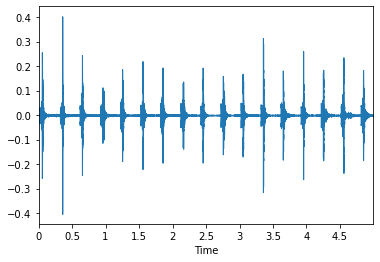

In [93]:
filename = valid[valid['category']=='clock_tick'].iloc[0]['filename']
wav, sr = librosa.load('audio/'+filename, sr=None)
librosa.display.waveplot(wav, sr)

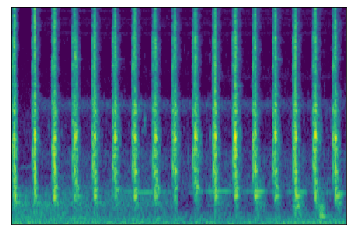

In [94]:
librosa.display.specshow(spec_to_image(get_melspectrogram_db('audio/'+filename, sr)), cmap='viridis')

In [95]:
train_data = ESC50Data('audio', train, 'filename', 'category')

100%|██████████| 1600/1600 [00:30<00:00, 53.14it/s]


In [96]:
valid_data = ESC50Data('audio', valid, 'filename', 'category')

100%|██████████| 400/400 [00:07<00:00, 53.92it/s]


In [97]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

In [98]:
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')

In [101]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

In [102]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 5 #60
train_losses = []
valid_losses = []

In [109]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [110]:
from torchvision.models import resnet34
resnet_model = resnet34(pretrained=True)
resnet_model.fc = nn.Linear(512,50)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

In [111]:
learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 5 #50
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]

def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer

train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

  0%|          | 0/5 [00:53<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
tl = np.asarray(resnet_train_losses).ravel()
vl = np.asarray(resnet_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


In [112]:
with open('esc50resnet.pth','wb') as f:
  torch.save(resnet_model, f)

In [113]:
import pickle
with open('indtocat.pkl','wb') as f:
  pickle.dump(train_data.i2c, f)

In [117]:
import IPython
with open('indtocat.pkl','rb') as f:
  indtocat = pickle.load(f)
filename='/content/ESC-50-master/audio/1-116765-A-41.wav'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
print(indtocat[ind])
IPython.display.display(IPython.display.Audio(filename=filename))

/Users/simon/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: [Errno 2] No such file or directory: '/content/ESC-50-master/audio/1-116765-A-41.wav'

In [116]:
!wget 'http://soundbible.com/grab.php?id=2215&type=wav' -O "dog.wav"
filename='dog.wav'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
print(indtocat[ind])
IPython.display.display(IPython.display.Audio(filename=filename))

zsh:1: command not found: wget


/Users/simon/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: [Errno 2] No such file or directory: 'dog.wav'

In [ ]:
!wget "http://soundbible.com/grab.php?id=1954&type=wav" -O "cat.wav"
filename='cat.wav'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
print(indtocat[ind])
IPython.display.display(IPython.display.Audio(filename=filename))